# Adding a qualitative feature to a synthetic population of households

Ce notebook part d'une génération de population synthétique de ménages générée sur la ville de Nantes. 
Cette population synthétique a un attribut qui est le nombre de voitures possédé par le ménage. Nous appellerons cette population, population initiale. 

Nous calulons les  marginaux pour chaque modalité de la population synthétique sous la forme d'un pourcentage pour cette modalité d'avoir une des modalités de l'attribut nombre de voiture. Par exemple, nous calculons le pourcentage pour un homme d'avoir une voiture. Ce tableau des marginaux peut être intérpêtés comme une distribution de probabiltés, c'est pourquoi, nous l'appellerons distributions marginales.

Nous appliquons l'algorithme bhepop2 qualitatif avec deux entrées

* La population synthétique sans l'attribut nombre de voiture possédé par le ménage. Nous l'appellerons population tronquée.
* les distributions marginales de cet attribut

L'algorithme Bhepop2 va donc inférer la population synthétique tronquée avec l'attribut nombre de véhicules. Nous appellerons la sortie de Bhepop2, la population reconstitutée.


In [2]:
import warnings
import pandas as pd
import pyarrow.feather as feather
from  bhepop2.max_entropy_enrich_qualitative import MaxEntropyEnrichment_qualitative
from bhepop2.tools import read_filosofi, compute_distribution, plot_analysis

warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.set_option("mode.chained_assignment", None)


## Data preparation

Read synthetic population which doesn't contain revenu information.

Pour passer de R à python (je retraduis le script R Epop2_R)
https://towardsdatascience.com/essential-guide-to-translating-between-python-and-r-7cb18b786e5d

Read Filosofi data and format dataframe.

In [17]:
synt_pop = feather.read_feather("../data/inputs/pop_synt_men_nantes.feather")
synt_pop = synt_pop.drop(['VOIT'], axis=1) # this attribute is redundant with the attribute 'Voit_rec'

synt_pop.head()

,SFM_agg,AGEREVQb_rec,sexe_rec,prof,Voit_rec
0,CSE,cat4,Homme,Retraite,2voit
1,CSE,cat4,Homme,Retraite,2voit
2,CSE,cat4,Homme,Retraite,2voit
3,CSE,cat4,Homme,Retraite,2voit
4,CSE,cat4,Homme,Retraite,2voit


### Calculation of  marginal distribution



In [18]:
def build_cross_table(pop:pd.DataFrame, names_attribute:list):
    """
    

    Parameters
    ----------
    pop : DataFrame synthesis population
    names_attribute: list of two strings
           name of attribute1 and name of attribute 2 

    Returns
    -------
    table_percentage : DataFrame
          proportion of modalities of attribute 2 given attribute 1


    """

   
    name_attribute1=names_attribute[0]
    name_attribute2=names_attribute[1]
    table_numbers=pd.crosstab(synt_pop[name_attribute2],synt_pop[name_attribute1]) 
    table_percentage_attribute2=table_numbers.transpose().sum()/table_numbers.transpose().sum().sum()
    table_percentage=table_numbers/table_numbers.sum()
    table_percentage['All']=table_percentage_attribute2
    table_percentage=table_percentage.transpose()
    table_percentage['modality']=table_percentage.index
    table_percentage['attribute']=name_attribute1
    
    return table_percentage


marginal_distribution=pd.concat(list(map(lambda a: build_cross_table(synt_pop, [a,'Voit_rec']),list(synt_pop.columns)[:-2])))
print(marginal_distribution)


Voit_rec     0voit     1voit     2voit     3voit modality     attribute
ATM       0.215885  0.401376  0.307951  0.074788      ATM       SFM_agg
CAE1      0.024035  0.243917  0.574045  0.158003     CAE1       SFM_agg
CAE2      0.014934  0.209368  0.652903  0.122794     CAE2       SFM_agg
CAE3      0.025977  0.241346  0.611276  0.121401     CAE3       SFM_agg
CSE       0.036350  0.402528  0.518663  0.042458      CSE       SFM_agg
FM        0.159056  0.641416  0.167709  0.031819       FM       SFM_agg
PS        0.300612  0.657207  0.032939  0.009241       PS       SFM_agg
All       0.143884  0.470726  0.331103  0.054286      All       SFM_agg
cat1      0.225318  0.472243  0.274788  0.027650     cat1  AGEREVQb_rec
cat2      0.087523  0.423909  0.430074  0.058494     cat2  AGEREVQb_rec
cat3      0.082288  0.426480  0.382459  0.108773     cat3  AGEREVQb_rec
cat4      0.096897  0.557830  0.318637  0.026635     cat4  AGEREVQb_rec
cat5      0.302326  0.570125  0.120128  0.007421     cat5  AGERE

## Synthetic Population 


synt_pop_defected=synt_pop.drop(['Voit_rec']) # attributes vehicles and number of vehicles are removed
synt_pop_defected.head()

## Run algorithm

In [19]:
modalities=list(marginal_distribution.index)
while 'All' in modalities: modalities.remove('All')


    
# Algorithm parameters
PARAMETERS = {
    "maxentropy_algorithm": "Nelder-Mead",
    "maxentropy_verbose": 1,
    }

# Optimisation preparation
enrich_class = MaxEntropyEnrichment_qualitative(
    synt_pop_defected,  marginal_distribution, parameters=PARAMETERS, seed=42
)

# Run optimisation
enrich_class.optimise()

# Assign data to synthetic population
pop = enrich_class.assign_feature_value_to_pop()

pop.head()

AssertionError: 

## Results analysis

### Data preparation

Format Filosofi data for comparison.

In [5]:
filosofi_formated = filosofi.copy()
del filosofi_formated["commune_id"]
del filosofi_formated["reference_median"]

filosofi_formated = filosofi_formated.melt(
    id_vars=["attribute", "modality"],
    value_vars=["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9"],
    value_name="feature",
    var_name="decile",
)
filosofi_formated["source"] = "Filosofi"

Format simulation data for comparison.

In [6]:
# distribution of all households
df_analysis = compute_distribution(pop)
df_analysis["attribute"] = "all"
df_analysis["modality"] = "all"

# distribution of each modality
for attribute in MODALITIES.keys():
    for modality in MODALITIES[attribute]:
        distribution = compute_distribution(pop[pop[attribute] == modality])
        distribution["attribute"] = attribute
        distribution["modality"] = modality

        df_analysis = pd.concat([df_analysis, distribution])

df_analysis["source"] = "bhepop2"

Merge observed Filosofi and simulation data.

In [7]:
# add filosofi data
df_analysis = pd.concat([df_analysis, filosofi_formated])

# format data
df_analysis = df_analysis.pivot(
    columns="source", index=["attribute", "modality", "decile"]
).reset_index()
df_analysis.columns = ["attribute", "modality", "decile", "Filosofi", "bhepop2"]

### Some plots

In [8]:
from IPython.display import Image

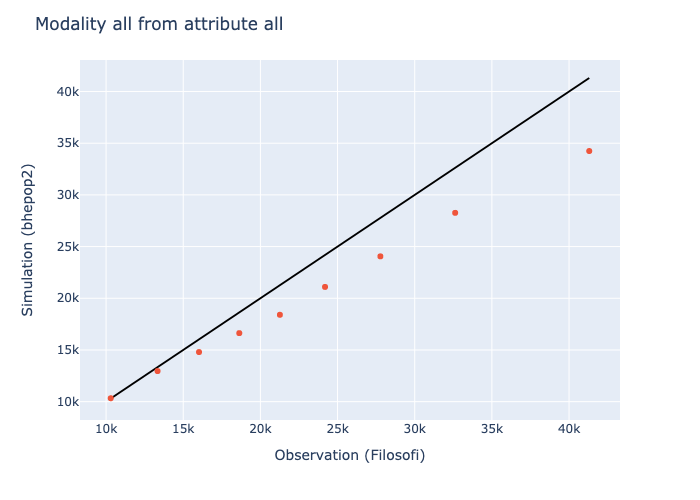

In [9]:
Image(plot_analysis(df_analysis, "all", "all").to_image())

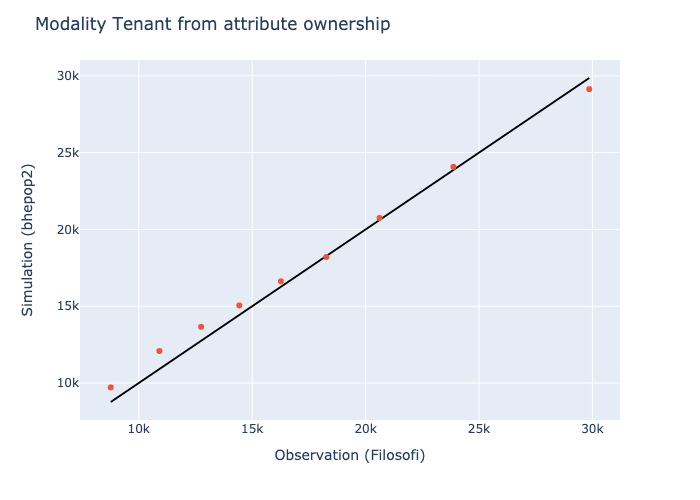

In [10]:
Image(plot_analysis(df_analysis, "ownership", "Tenant").to_image())

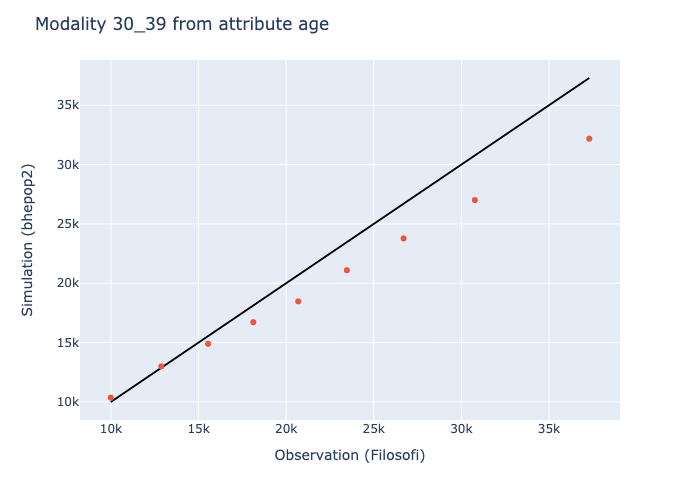

In [11]:
Image(plot_analysis(df_analysis, "age", "30_39").to_image())

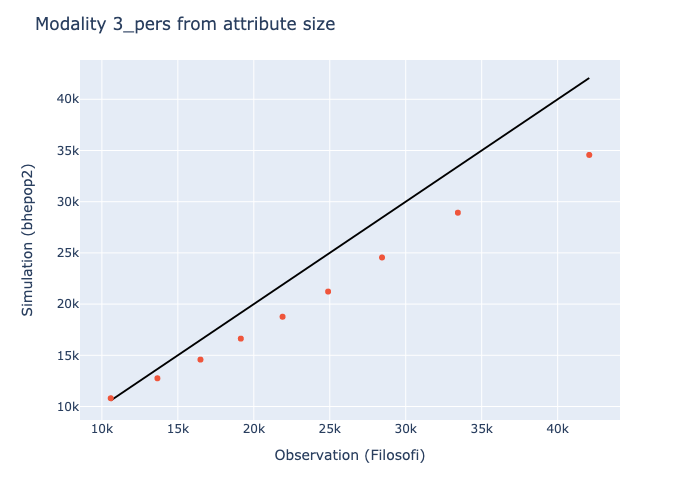

In [12]:
Image(plot_analysis(df_analysis, "size", "3_pers").to_image())

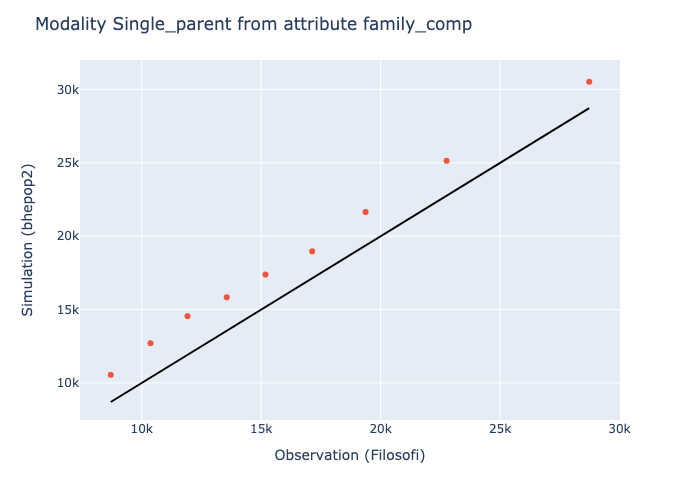

In [13]:
Image(plot_analysis(df_analysis, "family_comp", "Single_parent").to_image())